In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test  = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Missing values in training data

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


### Missing values in Test Data

In [7]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Assumptions
1. There are 891 rows in training data
2. Age plays an important role, children had more chances of survival
3. Cabin : Drop (Large no. of missing values)
4. Sex : Females had higher chances of survival

### Data Visualization

Percentage of women who survived: 74.20382165605095
Percentage of men who survived: 18.890814558058924


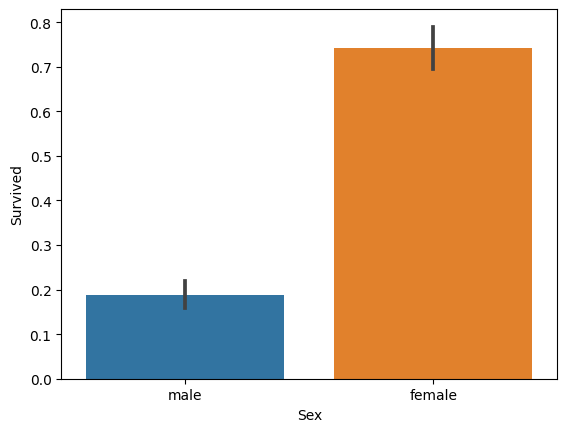

In [8]:
sns.barplot(x='Sex',y='Survived',data=train)
# Print Percentage
print("Percentage of women who survived:",train['Survived'][train['Sex']=='female'].value_counts(normalize=True)[1]*100)
print("Percentage of men who survived:",train['Survived'][train['Sex']=='male'].value_counts(normalize=True)[1]*100)

### PClass

Percentage of Pclass=1 who survived: 62.96296296296296
Percentage of Pclass=2 who survived: 47.28260869565217
Percentage of Pclass=3 who survived: 24.236252545824847


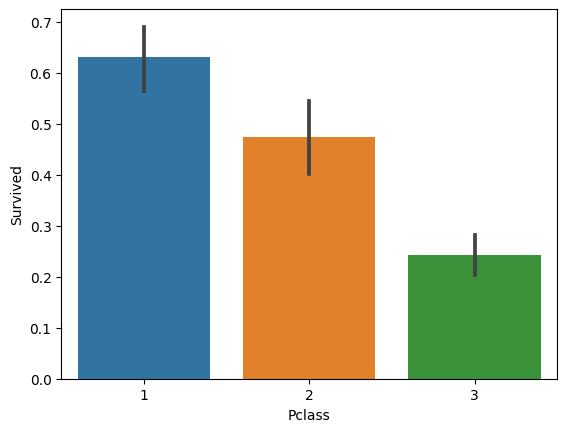

In [9]:
sns.barplot(x='Pclass',y='Survived',data=train)
print("Percentage of Pclass=1 who survived:",train['Survived'][train['Pclass']==1].value_counts(normalize=True)[1]*100)
print("Percentage of Pclass=2 who survived:",train['Survived'][train['Pclass']==2].value_counts(normalize=True)[1]*100)
print("Percentage of Pclass=3 who survived:",train['Survived'][train['Pclass']==3].value_counts(normalize=True)[1]*100)

### Age

In [10]:
# Filling null values with an arbitrary value
train.Age = train.Age.fillna(-0.5)
test.Age = test.Age.fillna(-0.5)

### Categorizing Age
1. -1 : 0  -> unknown
2.  0 : 5  -> Baby
3.  5 : 12 -> Child
4.  12: 18 -> Teenager
5.  18: 24 -> Student
6.  24: 35 -> Young Adult
7.  35: 60 -> Adult
8.  60 +   -> Senior

<Axes: xlabel='AgeGroup', ylabel='Survived'>

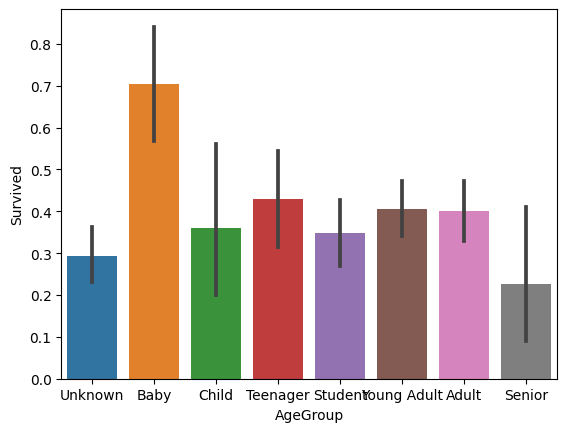

In [11]:
bins = [-1,0,5,12,18,24,35,60,np.inf]
labels = ["Unknown","Baby","Child","Teenager","Student","Young Adult","Adult","Senior"]
train["AgeGroup"] = pd.cut(train['Age'],bins=bins,labels=labels)
test["AgeGroup"] = pd.cut(test['Age'],bins=bins,labels=labels)

sns.barplot(x='AgeGroup',y='Survived',data=train)

A baby had maximum chances of survival.

In [12]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeGroup'],
      dtype='object')

### Dropping unimportant columns

In [13]:
train = train.drop(['Ticket','Cabin','Fare'],axis=1)
test  = test.drop(['Ticket','Cabin','Fare'],axis=1)

### Dealing with Missing Values

In [14]:
print("Number of people embarking in Southampton(S):")
southampton = train[train['Embarked']=='S'].shape[0]
print(southampton)

print("Number of people embarking in Cherbourg(C):")
cherbourg = train[train['Embarked']=='C'].shape[0]
print(cherbourg)

print("Number of people embarking in Queenstown(Q):")
queenstown = train[train['Embarked']=='Q'].shape[0]
print(queenstown)

Number of people embarking in Southampton(S):
644
Number of people embarking in Cherbourg(C):
168
Number of people embarking in Queenstown(Q):
77


In [15]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,AgeGroup
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,NaN,Adult
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,NaN,Senior


In [16]:
# Replace missing values in embarked with 'S'
train = train.fillna({'Embarked':'S'})

### Handling missing values in 'Age' column
1. Creating a new feature with the help of regex by taking out initials in each name and then group the passengers according to their initails.
2. Fill the missing age with the mode of age of people belonging to that group of initials.

In [17]:
# Combining both dataset to handle missing 'age' value in both
combine = [train,test]
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.',expand=False)
pd.crosstab(train['Title'],train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [18]:
# Clubbing all titles
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Capt','Col','Don','Dr','Major','Rev','Jonkheer',
                                                'Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace(['Countess','Lady','Sir'],'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    
train[['Title','Survived']].groupby(['Title'],as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.250000
5,Royal,1.000000


In [19]:
list(train[['Title','Survived']].groupby(['Title'],as_index=False).mean()['Title'])

['Master', 'Miss', 'Mr', 'Mrs', 'Rare', 'Royal']

In [20]:
title_mapping = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Royal':5,'Rare':6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,AgeGroup,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S,Student,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C,Adult,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S,Young Adult,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S,Young Adult,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,S,Young Adult,1


In [22]:
# Finding the mode of age groups for each Title
mr_age     = train[train['Title']==1]['AgeGroup'].mode() # Young Adult
miss_age   = train[train['Title']==2]['AgeGroup'].mode() # Student
mrs_age    = train[train['Title']==3]['AgeGroup'].mode() # Adult
master_age = train[train['Title']==4]['AgeGroup'].mode() # Baby
royal_age  = train[train['Title']==5]['AgeGroup'].mode() # Adult
rare_age   = train[train['Title']==6]['AgeGroup'].mode() # Adult

age_title_map = {1:'Young Adult',2:'Student',3:'Adult',4:'Baby',5:'Adult',6:'Adult'}

# Replacing the unknown values in the age group
for i in range(len(train['AgeGroup'])):
    if(train['AgeGroup'][i] == 'Unknown'):
        train['AgeGroup'][i] =age_title_map[train['Title'][i]]
        
for i in range(len(test['AgeGroup'])):
    if(test['AgeGroup'][i] == 'Unknown'):
        test['AgeGroup'][i] =age_title_map[test['Title'][i]]

In [23]:
len(train[train['Title']==2])

185

In [24]:
train[train['Title']==2]['AgeGroup'].value_counts()

AgeGroup
Student        71
Young Adult    33
Teenager       29
Baby           21
Adult          19
Child          11
Senior          1
Unknown         0
Name: count, dtype: int64

In the data, people with 'Title': Miss have most number of null values in Age column however instead of taking the mode of AgeGroup of people with 'Title': Miss as 'Unknown' we take it as 'Student' which is the 2nd most popular AgeGroup in this column


In [25]:
# There is no unknown value
train.AgeGroup.unique()

['Student', 'Adult', 'Young Adult', 'Baby', 'Teenager', 'Child', 'Senior']
Categories (8, object): ['Unknown' < 'Baby' < 'Child' < 'Teenager' < 'Student' < 'Young Adult' < 'Adult' < 'Senior']

In [26]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,AgeGroup,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,S,Student,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,C,Adult,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,S,Young Adult,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,S,Young Adult,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,S,Young Adult,1


In [27]:
train['Age'].value_counts()

Age
-0.50     177
 24.00     30
 22.00     27
 18.00     26
 28.00     25
         ... 
 36.50      1
 55.50      1
 0.92       1
 23.50      1
 74.00      1
Name: count, Length: 89, dtype: int64

In [28]:
# Convert categorical to numarical data
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
transform = ['Sex','AgeGroup','Embarked']
for i in transform:
    train[i] = le.fit_transform(train[i])

In [29]:
for i in transform:
    test[i] = le.fit_transform(test[i])

In [30]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,AgeGroup,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,1,6,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,1,3,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,2,6,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,2,4,3


### Machine Learning Model

In [31]:
X_train = train.drop(['PassengerId','Survived','Name','Age'],axis=1)
Y_train = train['Survived']
X_test  = test.drop(['PassengerId','Name','Age'],axis=1)

### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,Y_train)
y_pred = lr.predict(X_test)

In [33]:
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [34]:
ids = test['PassengerId']
output = pd.DataFrame({'PassengerId':ids,'Survived':y_pred})
output.to_csv('submission.csv',index=False)